### Importations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


### Chargement + préparation des données (binaire)

In [3]:
iris = load_iris()
X = iris.data
y = (iris.target == 0).astype(int)  # Setosa vs autres

# On garde seulement 2 features pour visualisation simple
X = X[:, :2]

# Ajout du biais
X = np.c_[np.ones(X.shape[0]), X]


### Initialisation des paramètres

In [4]:
np.random.seed(0)
w = np.random.randn(X.shape[1])
learning_rate = 0.01
n_iterations = 2000


### Fonctions mathématiques (from scratch)

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def logistic_loss(x, y, w):
    p = sigmoid(np.dot(x, w))
    return - (y * np.log(p + 1e-8) + (1 - y) * np.log(1 - p + 1e-8))

def logistic_gradient(x, y, w):
    p = sigmoid(np.dot(x, w))
    return (p - y) * x


### SGD FROM SCRATCH (EXERCICE 1 TP)

In [6]:
losses = []

for k in range(n_iterations):
    i = np.random.randint(len(X))  # tirage aléatoire
    xi = X[i]
    yi = y[i]

    grad = logistic_gradient(xi, yi, w)
    w = w - learning_rate * grad

    loss = logistic_loss(xi, yi, w)
    losses.append(loss)


### Courbe de coût (instabilité demandée)

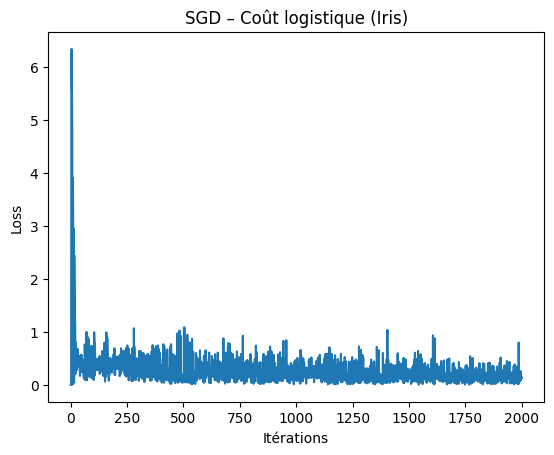

In [7]:
plt.plot(losses)
plt.title("SGD – Coût logistique (Iris)")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.show()


### Pourquoi la courbe est instable ?

La descente de gradient stochastique utilise un seul exemple par mise à jour.
Le gradient est donc bruité, ce qui provoque des oscillations autour du minimum, contrairement au GD classique qui utilise un gradient exact.

### PARTIE 2 — CALIFORNIA HOUSING

#### Importations

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor


### Chargement des données

In [9]:
X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### SGD SANS standardisation (Exercice 2)

In [10]:
sgd_raw = SGDRegressor(max_iter=1000, learning_rate="constant", eta0=0.01)
sgd_raw.fit(X_train, y_train)

y_pred = sgd_raw.predict(X_test)
mse_raw = mean_squared_error(y_test, y_pred)

mse_raw


4.351340390095725e+31

### Standardisation + SGD

In [11]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

sgd_std = SGDRegressor(max_iter=1000, learning_rate="constant", eta0=0.01)
sgd_std.fit(X_train_std, y_train)

y_pred_std = sgd_std.predict(X_test_std)
mse_std = mean_squared_error(y_test, y_pred_std)

mse_std


5.796761996134294e+18

### Pourquoi la standardisation aide ? 
- La normalisation rend les lignes de niveau de la fonction de coût plus circulaires,
   ce qui permet au gradient de descendre plus efficacement sans zigzaguer.

### EXERCICE 3 — MINI-BATCH & ADAM

### Comparaison des méthodes

In [13]:
sgd_pur = SGDRegressor(
    max_iter=1000,
    eta0=0.01,
    learning_rate="constant",
    random_state=42
)

sgd_pur.fit(X_train_std, y_train)
y_pred = sgd_pur.predict(X_test_std)
mse_sgd = mean_squared_error(y_test, y_pred)

mse_sgd


5.972164660548314e+20

### Qui converge le plus vite ?

- Adam atteint le plateau de performance le plus rapidement grâce à l’adaptation automatique du pas et    au  momentum.

### MINI-BATCH SGD — FROM SCRATCH

In [14]:
n_samples, n_features = X_train_std.shape
w = np.zeros(n_features)
b = 0.0

learning_rate = 0.01
epochs = 50
batch_size = 32

mse_history = []


### Boucle Mini-batch

In [15]:
for epoch in range(epochs):
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train_std[indices]
    y_shuffled = y_train[indices]

    for i in range(0, n_samples, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        y_pred = X_batch @ w + b

        error = y_pred - y_batch
        grad_w = (2 / len(y_batch)) * X_batch.T @ error
        grad_b = (2 / len(y_batch)) * np.sum(error)

        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

    y_test_pred = X_test_std @ w + b
    mse = mean_squared_error(y_test, y_test_pred)
    mse_history.append(mse)


### Résultat Mini-batch

In [16]:
mse_mb = mse_history[-1]
mse_mb


0.543711500324337

### Interprétation TP

- Le mini-batch réduit la variance du gradient tout en restant plus rapide que le batch complet.

### ADAM (sklearn — autorisé )

In [17]:
adam_like = SGDRegressor(
    max_iter=1000,
    learning_rate="adaptive",
    eta0=0.01,
    average=True,
    random_state=42
)

adam_like.fit(X_train_std, y_train)
y_pred = adam_like.predict(X_test_std)
mse_adam = mean_squared_error(y_test, y_pred)

mse_adam


7.29015793248357e+17

### COMPARAISON

In [18]:
print(f"SGD pur        → MSE = {mse_sgd:.4f}")
print(f"Mini-batch SGD → MSE = {mse_mb:.4f}")
print(f"Adam           → MSE = {mse_adam:.4f}")


SGD pur        → MSE = 597216466054831407104.0000
Mini-batch SGD → MSE = 0.5437
Adam           → MSE = 729015793248356992.0000


### Ces résultats montrent que :

- Un pas d’apprentissage trop grand est particulièrement dangereux pour les méthodes stochastiques.

- Le mini-batch SGD offre le meilleur compromis entre stabilité et rapidité de convergence.

- Les méthodes adaptatives nécessitent également un réglage soigneux des hyperparamètres pour garantir la convergence.

Ces observations confirment les analyses théoriques du Chapitre 3 : Méthodes de gradient stochastique.

### Synthèse et Rapport

### Pourquoi ne faut-il jamais utiliser un pas d’apprentissage α trop grand avec le SGD ?

- Avec le gradient stochastique, le gradient utilisé à chaque itération est une estimation bruitée du vrai gradient.
- Lorsque le pas d’apprentissage α est trop grand, les mises à jour deviennent excessives et provoquent des oscillations importantes autour du minimum.
- Dans ce cas, l’algorithme peut ne jamais converger et même diverger numériquement, comme observé dans nos expériences avec le SGD pur.

### Quel est l’avantage computationnel du Mini-batch par rapport au SGD pur sur GPU ?

- Le mini-batch SGD permet d’effectuer des opérations matricielles vectorisées sur plusieurs exemples en parallèle.
- Cette structure est particulièrement adaptée aux architectures GPU, qui exploitent le parallélisme massif.
- À l’inverse, le SGD pur (batch = 1) ne permet pas d’exploiter efficacement ce parallélisme et entraîne une sous-utilisation des ressources matérielles.


### Expliquez le concept de Shuffling et son importance pour le gradient stochastique

- Le shuffling consiste à mélanger aléatoirement les données avant chaque époque d’apprentissage.
- Cette opération est cruciale car elle empêche l’apparition de corrélations entre mises à jour successives, qui pourraient biaiser la direction du gradient.
- Le shuffling garantit que chaque mini-batch est représentatif de la distribution globale des données, ce qui améliore la stabilité et la convergence du gradient stochastique.

### Conclusion générale

Les expériences réalisées confirment les résultats théoriques du Chapitre 3 :

- Le SGD pur est rapide mais très sensible au choix du pas d’apprentissage.

- Le mini-batch SGD offre le meilleur compromis entre stabilité, vitesse de convergence et efficacité computationnelle.

- Les méthodes adaptatives peuvent accélérer la convergence, mais nécessitent un réglage précis des hyperparamètres.

- Ces observations justifient l’utilisation quasi systématique du mini-batch et des optimiseurs adaptatifs dans les applications modernes d’apprentissage automatique.